Нейроконсультант по ДИСЦИПЛИНАРНОМУ РЕГЛАМЕНТУ Российского футбольного союза (РФС)

In [ ]:
!pip install langchain_openai langchain openai tiktoken requests matplotlib pydantic pydantic_settings faiss-cpu

In [ ]:
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain.schema import AIMessage, HumanMessage, SystemMessage
from langchain.docstore.document import Document
from langchain.text_splitter import MarkdownHeaderTextSplitter, RecursiveCharacterTextSplitter
from langchain.vectorstores import FAISS
from openai import OpenAI
import tiktoken
import os
import re
import datetime
import requests
import matplotlib.pyplot as plt

# --------------------------------------------------------------
from pydantic import SecretStr
from pydantic_settings import BaseSettings, SettingsConfigDict

class Settings(BaseSettings):
    model_config = SettingsConfigDict(env_file='input',
                                      env_file_encoding='utf-8')
    openai_api_key: SecretStr

os.environ['OPENAI_API_KEY'] = Settings().openai_api_key.get_secret_value()
client = OpenAI()

In [ ]:
def load_document_text(url: str) -> str:
    match_ = re.search('/document/d/([a-zA-Z0-9-_]+)', url)
    if match_ is None:
        raise ValueError('Invalid Google Docs URL')
    doc_id = match_.group(1)
    response = requests.get(f'https://docs.google.com/document/d/{doc_id}/export?format=txt')
    response.raise_for_status()
    text = response.text
    return text


def load_and_duplicate_markdown(url):
    # Находим строки с разметкой MarkDown и дублируем их без разметки
    lines = load_document_text(url).split('\n')
    new_lines = []
    for line in lines:
        if '# ' in line:
            new_lines.append(line + '\n' + line.replace('#', ''))
        elif '## ' in line:
            new_lines.append(line + '\n' + line.replace('##', ''))
        elif '### ' in line:
            new_lines.append(line + '\n' + line.replace('###', ''))
        else:
            new_lines.append(line)
    return '\n'.join(new_lines)


# **************************************************************
text = load_and_duplicate_markdown('https://docs.google.com/document/d/1PGw5G8PSJ2S7vfPlge9j6G_x0zXFG67PMIitfwlP-c0/edit?usp=sharing')
print('К-во символов text:', len(text))

К-во символов text: 143932


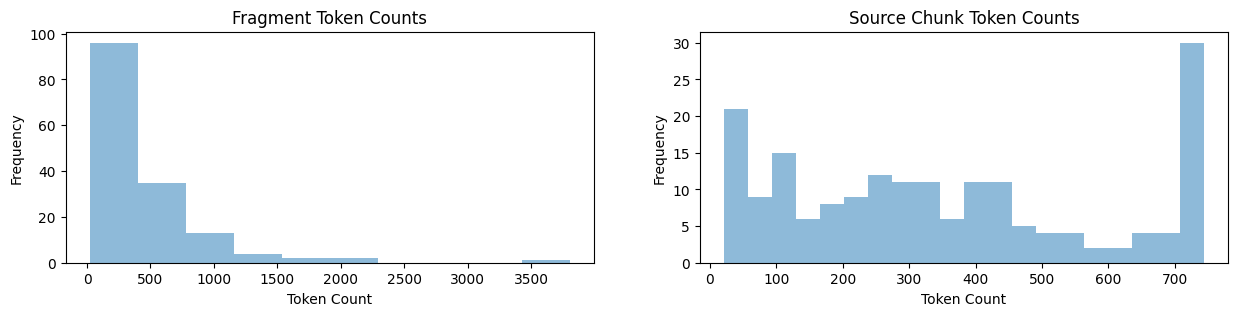

fragments:  153
source_chunks:  185


In [ ]:
def count_tokens(system_text, question, answer_text):
    messages = [SystemMessage(content=system_text),
                HumanMessage(content=question),
                AIMessage(content=answer_text)]
    return ChatOpenAI().get_num_tokens_from_messages(messages)


def num_tokens_from_string(string, encoding_name):
      """Возвращает количество токенов в строке"""
      encoding = tiktoken.get_encoding(encoding_name)
      num_tokens = len(encoding.encode(string))
      return num_tokens


def hist_plot(fragments, source_chunks):
    fragment_token_counts = [num_tokens_from_string(fragment.page_content, "cl100k_base") for fragment in fragments]
    source_chunk_token_counts = [num_tokens_from_string(chunk.page_content, "cl100k_base") for chunk in source_chunks]

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 3))
    ax1.hist(fragment_token_counts, bins=10, alpha=0.5, label='Fragments')
    ax1.set_title('Fragment Token Counts')
    ax1.set_xlabel('Token Count')
    ax1.set_ylabel('Frequency')
    plt.hist(source_chunk_token_counts, bins=20, alpha=0.5, label='Source Chunks')
    ax2.set_title('Source Chunk Token Counts')
    ax2.set_xlabel('Token Count')
    ax2.set_ylabel('Frequency')
    plt.show()


def split_text(text, max_count):
    headers_to_split_on = [
        ("#", "Header 1"),
        ("##", "Header 2"),
        ("###", "Header 3"),
    ]
    markdown_splitter = MarkdownHeaderTextSplitter(headers_to_split_on=headers_to_split_on)
    fragments = markdown_splitter.split_text(text)

    splitter = RecursiveCharacterTextSplitter(
        chunk_size=max_count,
        chunk_overlap=50,
        length_function=lambda x: num_tokens_from_string(x, "cl100k_base")
    )
    source_chunks = [
        Document(page_content=chunk, metadata=fragment.metadata)
        for fragment in fragments
        for chunk in splitter.split_text(fragment.page_content)
    ]
    hist_plot(fragments, source_chunks)
    return fragments, source_chunks

# *****************************************************************************
fragments, source_chunks = split_text(text, 750)
print("fragments: ", len(fragments))
print("source_chunks: ", len(source_chunks))

In [ ]:
embeddings = OpenAIEmbeddings()
db = FAISS.from_documents(source_chunks, embeddings)

def chunks_and_scores(query, db):
    docs_and_scores = db.similarity_search_with_score(query, k=4)
    print('Scores:', [doc[1] for doc in docs_and_scores])

In [ ]:
query = 'Право на участие в заседании Юрисдикционного органа'
chunks_and_scores(query, db)

Scores: [0.156737, 0.20942622, 0.23486353, 0.23581699]


In [ ]:
query = 'Есть ли жизнь на Марсе?'
chunks_and_scores(query, db)

Scores: [0.48263717, 0.48574024, 0.4890818, 0.48929158]


In [ ]:
def message_content_and_scores(topic, db, k):
    docs_and_scores = db.similarity_search_with_score(topic, k=k)
    message_content = ', '.join([f'\nChunk {i+1}: {doc[0].page_content}'
                                 for i, doc in enumerate(docs_and_scores)])
    scores = [doc[1] for doc in docs_and_scores]
    return message_content, scores


def gpt_35_turbo(messages, temp=0):
    return client.chat.completions.create(
        model="gpt-3.5-turbo-0125",
        messages=messages,
        temperature=temp)


def print_tokens_count(completion, info=''):
    print(info)
    print(f'Вопрос: {completion.usage.prompt_tokens} токенов. '
          f'\nОтвет: {completion.usage.completion_tokens} токенов. '
          f'\nВсего: {completion.usage.total_tokens} токенов.')
    print(datetime.datetime.now(), '\n')


def answer_gpt(system, topic, db, k=4, temp=0, verbose=0, info=''):
    message_content, scores = message_content_and_scores(topic, db, k)

    if verbose:
        print(' Message_content:\n', message_content)

    messages = [
        {"role": "system", "content": system},
        {"role": "user",
         "content":
        f"Ответь на вопрос. Документ с информацией для ответа: {message_content}\n\nВопрос: \n{topic}"}
    ]
    completion = gpt_35_turbo(messages, temp)

    print('Symbols Message_content:', len(message_content))
    print('Scores:', scores)
    print_tokens_count(completion, info=info)
    return completion.choices[0].message.content


system = "Ты консультант по ДИСЦИПЛИНАРНОМУ РЕГЛАМЕНТУ Российского футбольного союза (РФС). \
Ответь на вопрос на основе Документа с информацией. Не придумывай ничего от себя, отвечай максимально \
по Документу. Не упоминай Документ с информацией при ответе. Никто ничего не должен знать про \
Документ с информацией для ответа. Ты должен отвечать на вопросы только по темам Документа с информацией. \
Ты не должен отвечать на вопросы, которые не связанны с темами, содержащимися в Документе с информацией. \
Если будет вопрос не связанный с темами Документа, ответь, что ты можешь отвечать на вопросы только \
о ДИСЦИПЛИНАРНОМОМ РЕГЛАМЕНТЕ Российского футбольного союза (РФС)."

In [ ]:
topic = 'Расскажи о Праве на участие в заседании Юрисдикционного органа'
answer_gpt(system, topic, db)

Symbols Message_content: 3310
Scores: [0.17942652, 0.2266725, 0.24486713, 0.24971655]

Вопрос: 1867 токенов. 
Ответ: 313 токенов. 
Всего: 2180 токенов.
2024-02-12 22:05:13.232010 



'Любое лицо, в отношении которого ведется производство по делу, имеет право присутствовать на заседании Юрисдикционного органа и пользоваться всеми процессуальными правами, такими как знакомство с материалами дела, дача объяснений, представление своей аргументации и доказательств, требование предъявления доказательств, задавание вопросов и заявление отводов. Юрисдикционный орган обязан уведомить такое лицо о дате, месте и времени проведения заседания и не имеет права отказать ему в участии. Важно отметить, что отсутствие на заседании лица, в отношении которого ведется производство по делу, не влияет на законность решения только при условии, что такое лицо было своевременно уведомлено о заседании, и его процессуальные права были обеспечены.'

In [ ]:
topic = 'Есть ли жизнь на Марсе?'
answer_gpt(system, topic, db)

Symbols Message_content: 160
Scores: [0.48263717, 0.48574024, 0.4890818, 0.48929158]

Вопрос: 470 токенов. 
Ответ: 59 токенов. 
Всего: 529 токенов.
2024-02-12 22:05:26.634173 



'Я могу отвечать только на вопросы о ДИСЦИПЛИНАРНОМ РЕГЛАМЕНТЕ Российского футбольного союза (РФС).'